In [1]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [2]:
class ABENet(nn.Module):
    def __init__(self, N, has_key=True):
        super(ABENet, self).__init__()
        self.N = N
        
        self.fc    = nn.Linear(in_features=2*N if has_key else N, out_features=2*N)
        self.conv1 = nn.Conv1d(kernel_size=4, in_channels=1, out_channels=2, stride=1, padding=2)
        self.conv2 = nn.Conv1d(kernel_size=2, in_channels=2, out_channels=4, stride=2)
        self.conv3 = nn.Conv1d(kernel_size=1, in_channels=4, out_channels=4, stride=1)
        self.conv4 = nn.Conv1d(kernel_size=1, in_channels=4, out_channels=1, stride=1)

    def forward(self, x):
        x = torch.sigmoid( self.fc(x) )
        x = x.view(-1, 1, 2*self.N)
        x = torch.sigmoid( self.conv1(x) )
        x = torch.sigmoid( self.conv2(x) )
        x = torch.sigmoid( self.conv3(x) )
        x = torch.tanh(    self.conv4(x) )
        x = x.view(-1, self.N)
        return x

In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

![symmetric_encryption](img/symmetric_enc.png)

In [5]:
N = 16 # [16, 32, 64]
minibatch_size = 4096 # [256..4096]

A = ABENet(N, has_key=True).to(DEVICE)
B = ABENet(N, has_key=True).to(DEVICE)
E = ABENet(N, has_key=False).to(DEVICE)

In [6]:
#l1_norm = lambda P1, P: torch.mean( torch.sum( torch.abs(P1 - P), dim=1 ), dim=0 ) # mean of batch
l1_norm = nn.L1Loss()
loss_eve = l1_norm
loss_bob = l1_norm
#loss_alicebob = lambda P_bob, P_eve, P: loss_bob(P_bob, P) + (((N/2 - loss_eve(P_eve, P))**2) / ((N/2)**2))
loss_alicebob = lambda P_bob, P_eve, P: loss_bob(P_bob, P) + (((1.0 - loss_eve(P_eve, P))**2))

In [7]:
def reconstruction_error(Out, Original):
    return torch.mean( torch.sum( torch.sign(Original) != torch.sign(Out), dim=1)
                       .to(torch.float), dim=0).item()

In [8]:
def gen_bitstring(N, batch_size=minibatch_size):
    return torch.randint(low=0, high=2, size=(batch_size,N), dtype=torch.float).to(DEVICE)*2-1

In [9]:
def train_abe(A, B, E,
              lr=0.0008,
              max_iter=150000,
              debug_print=1000,
              loss_eve=loss_eve,
              loss_alicebob=loss_alicebob,
              stop_condition=(lambda AB_loss, E_loss, AB_rec, E_rec:
                              #AB_loss < 0.005 and E_loss > 0.5
                              AB_rec < 0.05 and E_rec > 7.5)):
    
    # Optimizers
    A_optimizer = optim.Adam(A.parameters(), lr=0.0008)
    B_optimizer = optim.Adam(B.parameters(), lr=0.0008)
    E_optimizer = optim.Adam(E.parameters(), lr=0.0008)

    ABs = [] # AB loss values
    Es  = [] # E loss values

    Rec_B = []
    Rec_E = []
    
    [X.train() for X in [A,B,E]] # Set models in training mode

    start_time = time.time()
    for ic in range(max_iter):
        # Train A/B for 1 minibtach and E for 2 minibatches to give it some advantage
        for who, num_minibatches in [('AB', 1), ('E', 2)]:
            for _ in range(num_minibatches):
                P = gen_bitstring(N, batch_size=minibatch_size)
                K = gen_bitstring(N, batch_size=minibatch_size) 

                C     = A(torch.cat((P, K), dim=1))
                P_bob = B(torch.cat((C, K), dim=1))
                P_eve = E(C)

                if who == 'AB':
                    A_optimizer.zero_grad()
                    B_optimizer.zero_grad()
                    AB_loss = loss_alicebob(P_bob, P_eve, P)
                
                    AB_loss.backward()
                    A_optimizer.step()
                    B_optimizer.step()
                
                elif who == 'E':
                    E_optimizer.zero_grad()
                    E_loss  = loss_eve(P_eve, P)
                    
                    E_loss.backward()
                    E_optimizer.step()

        if debug_print > 0 and ic % debug_print == (debug_print-1):
            elapsed_time = time.time() - start_time
            print("[{:6d}] AB_loss: {:2.4f} E_loss: {:2.4f} Elapsed Time: {}".format(
                ic+1, AB_loss, E_loss, time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

        AB_rec = reconstruction_error(P, P_bob)
        E_rec = reconstruction_error(P, P_eve)
        Rec_B.append(AB_rec)
        Rec_E.append(E_rec)
        ABs.append(AB_loss.item())
        Es.append(E_loss.item())

        if stop_condition(AB_loss, E_loss, AB_rec, E_rec):
            break

    [X.train(False) for X in [A,B,E]]
    return ABs, Es, Rec_B, Rec_E

In [30]:
ABs, Es, RBs, ERs = train_abe(A,B,E, max_iter=15000)

[  1000] AB_loss: 1.0012 E_loss: 0.9985 Elapsed Time: 00:00:34
[  2000] AB_loss: 1.0029 E_loss: 0.9963 Elapsed Time: 00:01:08
[  3000] AB_loss: 1.0014 E_loss: 1.0021 Elapsed Time: 00:01:43
[  4000] AB_loss: 0.1140 E_loss: 0.7545 Elapsed Time: 00:02:17
[  5000] AB_loss: 0.0258 E_loss: 0.8682 Elapsed Time: 00:02:52
[  6000] AB_loss: 0.0118 E_loss: 0.9116 Elapsed Time: 00:03:26
[  7000] AB_loss: 0.0072 E_loss: 0.9356 Elapsed Time: 00:04:01


In [10]:
def plot_abe_losses(ABs, Es, ylabel="Loss"):
    plt.figure(figsize=(14,8))
    plt.plot(range(1, len(ABs)+1), ABs, label='Alice/Bob')
    plt.plot(range(1, len(Es)+1), Es, label='Eve')
    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True, which='both')
    plt.show()

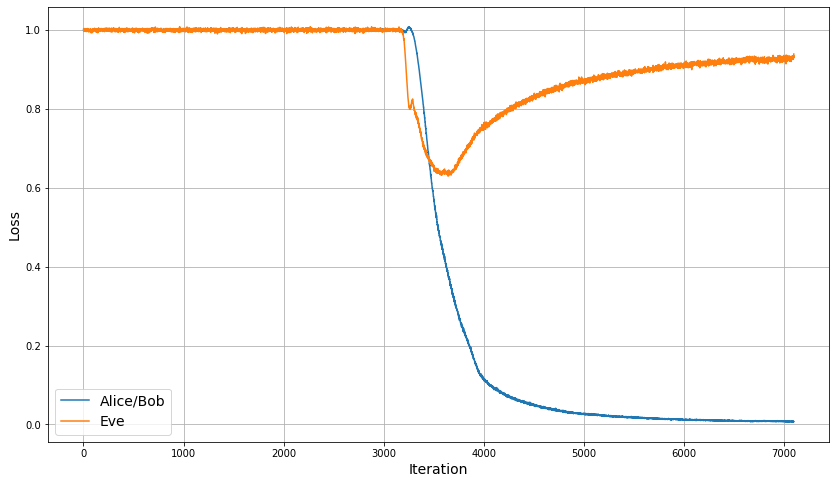

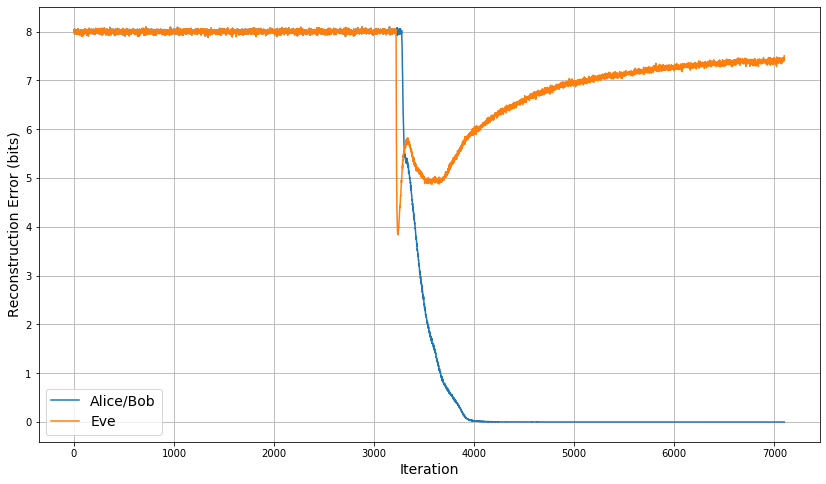

In [32]:
plot_abe_losses(ABs, Es)
plot_abe_losses(RBs, ERs, ylabel="Reconstruction Error (bits)")

In [11]:
def test_enc(A,B,E, debug=True):
    with torch.no_grad():
        P = gen_bitstring(N, batch_size=1)
        K = gen_bitstring(N, batch_size=1)
        C = A(torch.cat((P, K), dim=1))
        D = B(torch.cat((C, K), dim=1))
        F = E(C)
        if debug:
            print ("P:\n", P.cpu())
            print ("K:\n", K.cpu())
            print ("A(P,K):\n", C.cpu())
            print ("B(A(P, K), K):\n", D.cpu())
            print ("E(A(P, K)):\n", F.cpu())
        return P, K, C, D, F

In [34]:
_ = test_enc(A,B,E, debug=True)

P:
 tensor([[-1.,  1., -1., -1.,  1., -1., -1., -1.,  1.,  1., -1., -1., -1.,  1.,
          1., -1.]])
K:
 tensor([[-1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,
         -1., -1.]])
A(P,K):
 tensor([[-0.2108, -0.4068,  0.5591,  0.5356, -0.5933,  0.5051,  0.5608, -0.4685,
          0.5518, -0.3741,  0.7064, -0.6699,  0.5502, -0.6388,  0.5095,  0.6827]])
B(A(P, K), K):
 tensor([[-0.9982,  0.9986, -0.9991, -0.9953,  0.9994, -0.9992, -0.9993, -0.9986,
          0.9992,  0.9995, -0.9961, -0.9981, -0.9992,  0.9990,  0.9981, -0.9973]])
E(A(P, K)):
 tensor([[-0.9996, -0.9998, -0.9999,  0.9998, -0.9998, -0.9998, -0.9998,  1.0000,
          0.9999, -0.9998,  1.0000, -0.9956, -0.9999, -0.9998, -0.9998,  1.0000]])


In [35]:
def test_BE(A, B, E):
    TEST_SIZE = 10000
    B_rec = 0
    E_rec = 0
        
    for I in range(TEST_SIZE):
        P, K, C, P_b, P_e = test_enc(A,B,E, debug=False)
        B_rec += reconstruction_error(P, P_b)
        E_rec += reconstruction_error(P, P_e)
    return B_rec/TEST_SIZE, E_rec/TEST_SIZE

testB, testE = test_BE(A, B, E)
print ("B: {:.4f}".format(testB))
print ("E: {:.4f}".format(testE))


B: 0.0000
E: 7.4283


In [12]:
def train_best_eve(A, E,
                   max_iter=250000,
                   retries=5,
                   debug_print=10000):

    Best_E_Rec = float("Inf")
    Best_E_loss = float("Inf")
    Best_E = None

    for es in range(retries):
        CE = ABENet(N, has_key=False).to(DEVICE)
        CE_optimizer = optim.Adam(CE.parameters(), lr=0.0008)
        CE.train()
        start_time = time.time()
        for ic in range(max_iter):
            P = gen_bitstring(N, batch_size=minibatch_size)
            K = gen_bitstring(N, batch_size=minibatch_size)
                   
            C       = A(torch.cat((P, K), dim=1))
            P_eve   = CE(C)
            CE_loss = loss_eve(P_eve, P)
            CE_optimizer.zero_grad()
            CE_loss.backward()
            CE_optimizer.step()

            if debug_print > 0 and ic % debug_print == (debug_print-1):
                elapsed_time = time.time() - start_time
                print("[{:d} - {:6d}] CE_loss: {:2.4f} Elapsed Time: {}".format(
                    es+1, ic+1, CE_loss, time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

            if CE_loss <= 0.05:
                raise RuntimeError("Optimal E found!")
                break
            
        if CE_loss.item() < Best_E_loss:
            Best_E_loss = CE_loss.item()
            Best_E = CE
            Best_E_Rec = reconstruction_error(P, P_eve)

    return Best_E, Best_E_loss, Best_E_Rec

In [38]:
Best_E, Best_E_loss, Best_E_Rec = train_best_eve(A, E, retries=1, max_iter=20000)
Best_E_loss

[1 -  10000] CE_loss: 0.8267 Elapsed Time: 00:01:39
[1 -  20000] CE_loss: 0.8188 Elapsed Time: 00:03:18


0.8187873959541321

In [13]:
# Train new A,B,E and validate them for 20 times
def validate(num_times=20, max_iter_abe=15000, retries=5, max_iter_e=15000):
    AB     = []
    AB_rec = []
    BE     = []
    BE_rec = []
    start_time = time.time()
    for n in range(num_times):
        A = ABENet(N, has_key=True).to(DEVICE)
        B = ABENet(N, has_key=True).to(DEVICE)
        E = ABENet(N, has_key=False).to(DEVICE)
        ABs, Es, RABs, REs = train_abe(A,B,E, max_iter=max_iter_abe, debug_print=5000)
        _, Best_E_loss, BRE = train_best_eve(
            A, E, retries=retries, max_iter=max_iter_e, debug_print=7500)
        AB.append(ABs[-1])
        AB_rec.append(RABs[-1])
        BE.append(Best_E_loss)
        BE_rec.append(BRE)
        elapsed_time = time.time() - start_time
        print("[N: {}] AB_loss: {:2.4f} E_loss: {:2.4f} Elapsed Time: {}".format(
            n+1, ABs[-1], Best_E_loss, time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

    return AB, BE, AB_rec, BE_rec


In [40]:
AB, BE, AB_rec, BE_rec = validate(num_times=5, retries=5, max_iter_abe=15000, max_iter_e=15000)

[  5000] AB_loss: 1.0015 E_loss: 0.9952 Elapsed Time: 00:02:52
[1 -   7500] CE_loss: 0.7583 Elapsed Time: 00:01:14
[1 -  15000] CE_loss: 0.7390 Elapsed Time: 00:02:28
[2 -   7500] CE_loss: 0.7705 Elapsed Time: 00:01:14
[2 -  15000] CE_loss: 0.7628 Elapsed Time: 00:02:29
[3 -   7500] CE_loss: 0.7422 Elapsed Time: 00:01:14
[3 -  15000] CE_loss: 0.7424 Elapsed Time: 00:02:28
[4 -   7500] CE_loss: 0.7452 Elapsed Time: 00:01:14
[4 -  15000] CE_loss: 0.7327 Elapsed Time: 00:02:28
[5 -   7500] CE_loss: 0.7491 Elapsed Time: 00:01:14
[5 -  15000] CE_loss: 0.7414 Elapsed Time: 00:02:28
[N: 1] AB_loss: 0.0069 E_loss: 0.7327 Elapsed Time: 00:17:56
[  5000] AB_loss: 0.0096 E_loss: 0.9216 Elapsed Time: 00:02:52
[1 -   7500] CE_loss: 0.8409 Elapsed Time: 00:01:14
[1 -  15000] CE_loss: 0.8369 Elapsed Time: 00:02:29
[2 -   7500] CE_loss: 0.8428 Elapsed Time: 00:01:14
[2 -  15000] CE_loss: 0.8426 Elapsed Time: 00:02:29
[3 -   7500] CE_loss: 0.8666 Elapsed Time: 00:01:14
[3 -  15000] CE_loss: 0.8595 Elap

In [16]:
def plot_best_eves(AB, BE):
    plt.figure(figsize=(14,8))
    plt.scatter(AB,BE, marker='x')
    plt.xlabel("Alice-Bob Error", fontsize=14)
    plt.ylabel("Best Eve Error", fontsize=14)
    plt.grid(True, which='both')
    plt.show()

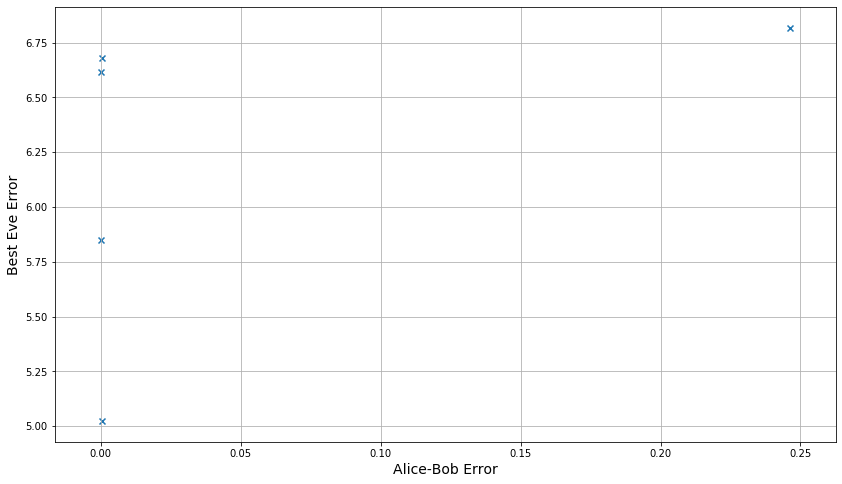

In [41]:
plot_best_eves(AB_rec, BE_rec)

In [15]:
_, _, AB_rec_1, BE_rec_1 = validate(num_times=10, retries=5, max_iter_abe=15000, max_iter_e=15000)


[  5000] AB_loss: 0.0070 E_loss: 0.9307 Elapsed Time: 00:02:51


[1 -   7500] CE_loss: 0.8475 Elapsed Time: 00:01:14


[1 -  15000] CE_loss: 0.8476 Elapsed Time: 00:03:26


[2 -   7500] CE_loss: 0.8407 Elapsed Time: 00:02:14


[2 -  15000] CE_loss: 0.8296 Elapsed Time: 00:04:28


[3 -   7500] CE_loss: 0.8339 Elapsed Time: 00:02:14


[3 -  15000] CE_loss: 0.8385 Elapsed Time: 00:04:29


[4 -   7500] CE_loss: 0.8570 Elapsed Time: 00:02:14


[4 -  15000] CE_loss: 0.8444 Elapsed Time: 00:04:29


[5 -   7500] CE_loss: 0.8446 Elapsed Time: 00:02:14


[5 -  15000] CE_loss: 0.8379 Elapsed Time: 00:04:29
[N: 1] AB_loss: 0.0072 E_loss: 0.8296 Elapsed Time: 00:24:16


[  5000] AB_loss: 0.0168 E_loss: 0.9023 Elapsed Time: 00:05:19


[1 -   7500] CE_loss: 0.8385 Elapsed Time: 00:02:14


[1 -  15000] CE_loss: 0.8281 Elapsed Time: 00:04:29


[2 -   7500] CE_loss: 0.8341 Elapsed Time: 00:02:14


[2 -  15000] CE_loss: 0.8240 Elapsed Time: 00:04:28


[3 -   7500] CE_loss: 0.8174 Elapsed Time: 00:02:14


[3 -  15000] CE_loss: 0.8126 Elapsed Time: 00:04:29


[4 -   7500] CE_loss: 0.8100 Elapsed Time: 00:02:14


[4 -  15000] CE_loss: 0.8095 Elapsed Time: 00:04:28


[5 -   7500] CE_loss: 0.8350 Elapsed Time: 00:02:14


[5 -  15000] CE_loss: 0.8305 Elapsed Time: 00:04:29
[N: 2] AB_loss: 0.0083 E_loss: 0.8095 Elapsed Time: 00:53:10


[  5000] AB_loss: 0.0243 E_loss: 0.8825 Elapsed Time: 00:05:19


[1 -   7500] CE_loss: 0.8439 Elapsed Time: 00:02:14


[1 -  15000] CE_loss: 0.8462 Elapsed Time: 00:04:29


[2 -   7500] CE_loss: 0.8326 Elapsed Time: 00:02:14


[2 -  15000] CE_loss: 0.8256 Elapsed Time: 00:04:28


[3 -   7500] CE_loss: 0.8218 Elapsed Time: 00:02:14


[3 -  15000] CE_loss: 0.8305 Elapsed Time: 00:04:29


[4 -   7500] CE_loss: 0.8272 Elapsed Time: 00:02:14


[4 -  15000] CE_loss: 0.8285 Elapsed Time: 00:04:29


[5 -   7500] CE_loss: 0.8421 Elapsed Time: 00:02:14


[5 -  15000] CE_loss: 0.8354 Elapsed Time: 00:04:29
[N: 3] AB_loss: 0.0076 E_loss: 0.8256 Elapsed Time: 01:22:26


[  5000] AB_loss: 0.5181 E_loss: 0.6630 Elapsed Time: 00:05:19


[ 10000] AB_loss: 0.0365 E_loss: 0.9340 Elapsed Time: 00:10:39


[1 -   7500] CE_loss: 0.8252 Elapsed Time: 00:02:14


[1 -  15000] CE_loss: 0.8134 Elapsed Time: 00:04:28


[2 -   7500] CE_loss: 0.8448 Elapsed Time: 00:02:14


[2 -  15000] CE_loss: 0.8405 Elapsed Time: 00:04:29


[3 -   7500] CE_loss: 0.8425 Elapsed Time: 00:02:14


[3 -  15000] CE_loss: 0.8330 Elapsed Time: 00:04:29


[4 -   7500] CE_loss: 0.8265 Elapsed Time: 00:02:14


[4 -  15000] CE_loss: 0.8191 Elapsed Time: 00:04:29


[5 -   7500] CE_loss: 0.8269 Elapsed Time: 00:02:14


[5 -  15000] CE_loss: 0.8220 Elapsed Time: 00:04:29
[N: 4] AB_loss: 0.0049 E_loss: 0.8134 Elapsed Time: 01:57:35


[  5000] AB_loss: 0.0077 E_loss: 0.9277 Elapsed Time: 00:05:19


[1 -   7500] CE_loss: 0.7881 Elapsed Time: 00:02:14


[1 -  15000] CE_loss: 0.7850 Elapsed Time: 00:04:28


[2 -   7500] CE_loss: 0.8155 Elapsed Time: 00:02:14


[2 -  15000] CE_loss: 0.8101 Elapsed Time: 00:04:29


[3 -   7500] CE_loss: 0.7843 Elapsed Time: 00:02:14


[3 -  15000] CE_loss: 0.7786 Elapsed Time: 00:04:29


[4 -   7500] CE_loss: 0.7939 Elapsed Time: 00:02:14


[4 -  15000] CE_loss: 0.7927 Elapsed Time: 00:04:28


[5 -   7500] CE_loss: 0.7988 Elapsed Time: 00:02:14


[5 -  15000] CE_loss: 0.7872 Elapsed Time: 00:04:28
[N: 5] AB_loss: 0.0082 E_loss: 0.7786 Elapsed Time: 02:25:21


[  5000] AB_loss: 0.0696 E_loss: 0.8080 Elapsed Time: 00:05:19


[1 -   7500] CE_loss: 0.8556 Elapsed Time: 00:02:14


[1 -  15000] CE_loss: 0.8540 Elapsed Time: 00:04:28


[2 -   7500] CE_loss: 0.8455 Elapsed Time: 00:02:14


[2 -  15000] CE_loss: 0.8446 Elapsed Time: 00:04:29


[3 -   7500] CE_loss: 0.8411 Elapsed Time: 00:02:14


[3 -  15000] CE_loss: 0.8404 Elapsed Time: 00:04:28


[4 -   7500] CE_loss: 0.8434 Elapsed Time: 00:02:14


[4 -  15000] CE_loss: 0.8338 Elapsed Time: 00:04:29


[5 -   7500] CE_loss: 0.8227 Elapsed Time: 00:02:14


[5 -  15000] CE_loss: 0.8280 Elapsed Time: 00:04:28
[N: 6] AB_loss: 0.0078 E_loss: 0.8280 Elapsed Time: 02:56:04


[  5000] AB_loss: 0.0409 E_loss: 0.8408 Elapsed Time: 00:05:19


[1 -   7500] CE_loss: 0.8343 Elapsed Time: 00:02:14


[1 -  15000] CE_loss: 0.8343 Elapsed Time: 00:04:28


[2 -   7500] CE_loss: 0.8461 Elapsed Time: 00:02:14


[2 -  15000] CE_loss: 0.8390 Elapsed Time: 00:04:29


[3 -   7500] CE_loss: 0.8446 Elapsed Time: 00:02:14


[3 -  15000] CE_loss: 0.8365 Elapsed Time: 00:04:29


[4 -   7500] CE_loss: 0.8300 Elapsed Time: 00:02:14


[4 -  15000] CE_loss: 0.8288 Elapsed Time: 00:04:29


[5 -   7500] CE_loss: 0.8426 Elapsed Time: 00:02:14


[5 -  15000] CE_loss: 0.8343 Elapsed Time: 00:04:28
[N: 7] AB_loss: 0.0082 E_loss: 0.8288 Elapsed Time: 03:27:15


[  5000] AB_loss: 0.0502 E_loss: 0.8841 Elapsed Time: 00:05:19


[ 10000] AB_loss: 0.0361 E_loss: 0.9535 Elapsed Time: 00:09:47


[ 15000] AB_loss: 0.0332 E_loss: 0.9631 Elapsed Time: 00:12:39


[1 -   7500] CE_loss: 0.8767 Elapsed Time: 00:01:14


[1 -  15000] CE_loss: 0.8770 Elapsed Time: 00:02:28


[2 -   7500] CE_loss: 0.8746 Elapsed Time: 00:01:14


[2 -  15000] CE_loss: 0.8791 Elapsed Time: 00:03:07


[3 -   7500] CE_loss: 0.8850 Elapsed Time: 00:02:11


[3 -  15000] CE_loss: 0.8757 Elapsed Time: 00:04:23


[4 -   7500] CE_loss: 0.8787 Elapsed Time: 00:02:11


[4 -  15000] CE_loss: 0.8696 Elapsed Time: 00:04:22


[5 -   7500] CE_loss: 0.8865 Elapsed Time: 00:02:11


[5 -  15000] CE_loss: 0.8882 Elapsed Time: 00:04:22
[N: 8] AB_loss: 0.0332 E_loss: 0.8696 Elapsed Time: 03:58:39


[  5000] AB_loss: 0.0149 E_loss: 0.9152 Elapsed Time: 00:03:32


[1 -   7500] CE_loss: 0.8514 Elapsed Time: 00:01:14


[1 -  15000] CE_loss: 0.8371 Elapsed Time: 00:02:28


[2 -   7500] CE_loss: 0.8628 Elapsed Time: 00:01:14


[2 -  15000] CE_loss: 0.8617 Elapsed Time: 00:02:28


[3 -   7500] CE_loss: 0.8429 Elapsed Time: 00:01:14


[3 -  15000] CE_loss: 0.8419 Elapsed Time: 00:02:28


[4 -   7500] CE_loss: 0.8644 Elapsed Time: 00:01:14


[4 -  15000] CE_loss: 0.8598 Elapsed Time: 00:02:28


[5 -   7500] CE_loss: 0.8598 Elapsed Time: 00:01:14


[5 -  15000] CE_loss: 0.8565 Elapsed Time: 00:02:28
[N: 9] AB_loss: 0.0089 E_loss: 0.8371 Elapsed Time: 04:15:15


[  5000] AB_loss: 0.0774 E_loss: 0.9123 Elapsed Time: 00:02:52


[ 10000] AB_loss: 0.0649 E_loss: 0.9636 Elapsed Time: 00:05:44


[ 15000] AB_loss: 0.0631 E_loss: 0.9643 Elapsed Time: 00:08:36


[1 -   7500] CE_loss: 0.9261 Elapsed Time: 00:01:14


[1 -  15000] CE_loss: 0.9283 Elapsed Time: 00:02:28


[2 -   7500] CE_loss: 0.9090 Elapsed Time: 00:01:14


[2 -  15000] CE_loss: 0.8893 Elapsed Time: 00:02:28


[3 -   7500] CE_loss: 0.9352 Elapsed Time: 00:01:14


[3 -  15000] CE_loss: 0.9162 Elapsed Time: 00:02:28


[4 -   7500] CE_loss: 0.9264 Elapsed Time: 00:01:14


[4 -  15000] CE_loss: 0.8901 Elapsed Time: 00:02:28


[5 -   7500] CE_loss: 0.9211 Elapsed Time: 00:01:14


[5 -  15000] CE_loss: 0.8976 Elapsed Time: 00:02:29
[N: 10] AB_loss: 0.0631 E_loss: 0.8893 Elapsed Time: 04:36:16


NameError: name 'plot_best_eves' is not defined

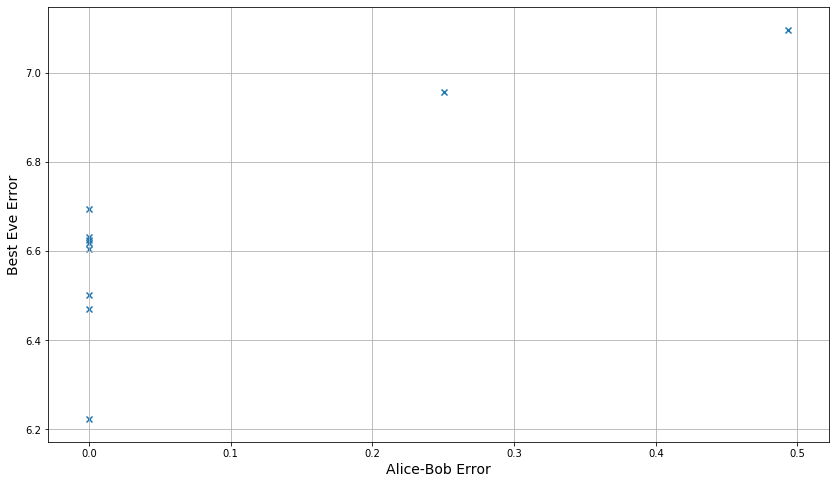

In [17]:
plot_best_eves(AB_rec_1, BE_rec_1)